<a href="https://colab.research.google.com/github/raghavadevarajeurs/DeepLearning/blob/main/Assignment3/Assignment3_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building 3 layer Neural Network using Numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as pltgo

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

#Generating sample data for 3d input and 2d output


In [2]:
def get_true_labels(X, weights_true, bias_true):
  return (X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

In [3]:
n_samples = 150
input_dim = 3
output_dim = 2

np.random.seed(1234)
X = np.random.uniform(-1, 1, (n_samples, input_dim))
print('Sample X: ' + str(X[:3]))

weights_true = np.array([[5, 1, 3], [2, 1, 1]])
bias_true = np.array([[1], [1]])

y_true = get_true_labels(X, weights_true, bias_true)
print('Sample y: ' + str(y_true[:3]))

Sample X: [[-0.6169611   0.24421754 -0.12454452]
 [ 0.57071717  0.55995162 -0.45481479]
 [-0.44707149  0.60374436  0.91627871]]
Sample y: [[-0.20484031  0.72218636]
 [ 5.6117988   3.41840964]
 [ 5.99979487  3.22969983]]


# Drawing the 3 Dimensional data plot

In [4]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

In [5]:
def plot_go_3d(x, y, y_pred=None):
  
  fig = pltgo.Figure()
  fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y.reshape([-1]),
                    name='y_true', mode='markers', marker=dict( size=10, color='dodgerblue', colorscale='Viridis', opacity=0.5)))
  if y_pred is not None:
    fig.add_trace(pltgo.Scatter3d(x = x[:,0], y = x[:,1], z = y_pred.reshape([-1]),
                   name='y_pred', mode='markers', marker=dict( size=10, color='goldenrod', colorscale='Viridis', opacity=0.5)))
  fig.update_layout(margin=dict(r=20, b=10, l=10, t=10))
  fig.show()

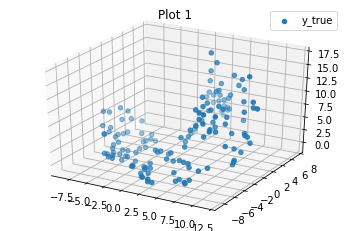

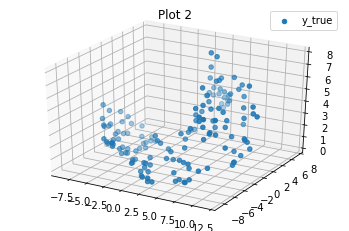

In [6]:
plot_3d('Plot 1', X, y_true[:,0])
plot_3d('Plot 2', X, y_true[:,1])

In [7]:
X_reduced = TSNE(n_components=2).fit_transform(X)
y_true_reduced = TSNE(n_components=1).fit_transform(y_true)
plot_go_3d(X_reduced,y_true_reduced)

#Building Nueral Network

##Loss Function - MSE

In [8]:
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient


##Linear Layer

In [9]:
class Layer:

  #Randomly initialize the weight and bias
  def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
    self.num_input_nodes = num_input_nodes
    self.num_output_nodes = num_output_nodes
    self.weights = np.random.rand(num_input_nodes, num_output_nodes)
    self.bias = np.random.rand((1))
    self.X = np.zeros([num_input_nodes])
    if activation == 'relu':
      self.activation = Relu()
    else: 
      self.activation = None
  
  #Compute forward pass
  def forward(self, X):
    self.X = X.copy()
    self.Z = X @ self.weights + self.bias
    if self.activation == None:
      return self.Z 
    else:
      return self.activation.forward(self.Z)

  #Perform gradient descent
  def backward(self, upstream_gradient):
    curr_upstream_gradient = upstream_gradient.copy()
    if self.activation != None:
      curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)
    
    # Compute gradient by taking dot product local gradient with upstream gradient
    self.dJdW = self.X.T @ curr_upstream_gradient
    # Upstream gradient is the sum of the gradient
    self.dJdb = curr_upstream_gradient.sum()
    # Compute the gradient of input X wrt to loss
    self.dJdX = curr_upstream_gradient @ self.weights.T
    return self.dJdX

  # Update weight and bias params with learning rate
  def update(self, learning_rate):
    self.weights = self.weights - learning_rate * self.dJdW
    self.bias = self.bias - learning_rate * self.dJdb

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{}\nWeights:\n{}\nBias:{}'.format(self.num_input_nodes, self.num_output_nodes, self.activation, self.X[:2], self.weights, self.bias)


##ReLU Activation function

In [10]:
class Relu:
  def __init__(self):
    self.input = np.array([])

  #Forward pass
  def forward(self, input):
    self.input = input.copy()
    self.output = np.clip(self.input, 0, None)
    return self.output
  
  #Backpropogation
  def backward(self, upstream_gradient):
    return (self.input > 0) * upstream_gradient
  
  # No update needed to ReLU members
  def update(self, learning_rate):
    return

  def __str__(self):
    return 'ReLu'

##Neural Net Architecture

In [11]:
class NeuralNet:
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation))

    print('Neural Net Architecture:')
    for i, layer in enumerate(self.layers):
      print('=== Layer {} ==='.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    curr_out = inputs.copy()
    for l in self.layers:
      curr_out = l.forward(curr_out)
    return curr_out
  
  def backward(self, y_pred, y_true):
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    print('Error: ', mean_squared_error(y_true, y_pred))
    loss_gradient = mse.backward()

    gradient = loss_gradient.copy()
    for layer in reversed(self.layers):
      gradient = layer.backward(gradient)
    
  def update(self, learning_rate):
    for layer in self.layers:
      layer.update(learning_rate)
  
  # Training loop over number of epochs
  def fit(self, X, y_true, epochs):
    for i in range(epochs):
      y_pred = self.forward(X)
      self.backward(y_pred, y_true)
      self.update(learning_rate)

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

#HyperParameters

In [12]:
epochs = 150
learning_rate = 0.01

n_inputs = X.shape[1]
n_outputs = y_true.shape[1]

#Training NN without any activation fucntion

In [13]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation=None)
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final Mean Squared Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.28159658 0.67669995 0.49573171 0.79114198]
 [0.21883353 0.74619584 0.45411105 0.40826233]
 [0.92264349 0.15072064 0.13098285 0.38189008]]
Bias:[0.5419866]
=== Layer 1 ===
Layer: (4,3) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.94437016 0.32325877 0.09744198]
 [0.94738726 0.85703482 0.02603686]
 [0.11789368 0.82937638 0.13847429]
 [0.56947114 0.47777541 0.30668648]]
Bias:[0.05660708]
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.93683521 0.9040036 ]
 [0.72223542 0.65407818]
 [0.39220994 0.97367479]]
Bias:[0.71100761]

Error:  5.064479241442923
Error:  4.291509754648538
Error:  3.7203465820311186
Error:  3.296507583221104
Error:  2.9826584593160783
Error:  2.749744306136445
Error:  2.575824519419605
Error:  2.4447645590429143
Error:  2.344936732991366
Error:  2.268030259121796
Error:  2.208114357103842
Error:  2.160938651191685
Err

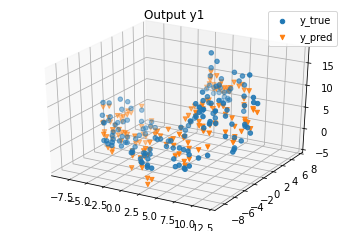

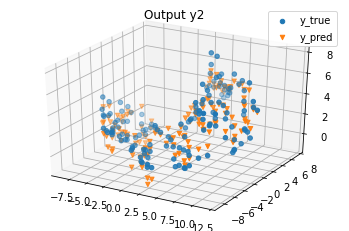

In [14]:
plot_3d('Output y1', X, y_true[:,0], y_pred[:,0])
plot_3d('Output y2', X, y_true[:,1], y_pred[:,1])

In [15]:
X_plot = TSNE(n_components=2).fit_transform(X)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)

#Training NN with ReLU activation function

In [16]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final Mean Squared Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[0.57560745 0.079372   0.04232202 0.8570225 ]
 [0.14754214 0.10307771 0.10634875 0.29325156]
 [0.53011683 0.86632552 0.86878375 0.3565033 ]]
Bias:[0.09812746]
=== Layer 1 ===
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[0.43822729 0.94748623 0.04159502]
 [0.31084756 0.78228691 0.79551015]
 [0.85258065 0.54389106 0.59062857]
 [0.13910797 0.03472366 0.15525958]]
Bias:[0.75691947]
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[0.36878243 0.28281236]
 [0.24179872 0.87135192]
 [0.36709439 0.88803578]]
Bias:[0.94987866]

Error:  11.096694772862072
Error:  9.673450515735308
Error:  8.402708973023438
Error:  7.328945626968151
Error:  6.4570065757402615
Error:  5.749317779467056
Error:  5.171443555662896
Error:  4.705623430197122
Error:  4.325821207214486
Error:  4.006041941231201
Error:  3.7319088075597815
Error:  3.4918354931464464
E

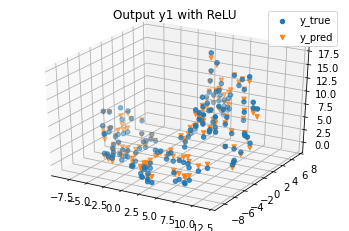

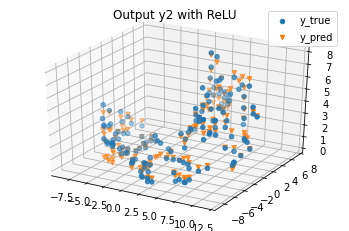

In [17]:
plot_3d('Output y1 with ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output y2 with ReLU', X, y_true[:,1], y_pred[:,1])

In [18]:
X_plot = TSNE(n_components=2).fit_transform(X)
y_true_plot = TSNE(n_components=1).fit_transform(y_true)
y_pred_plot = TSNE(n_components=1).fit_transform(y_pred)
plot_go_3d(X_plot,y_true_plot,y_pred_plot)